# Method 6 - Rest Ideas After 15

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 15].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

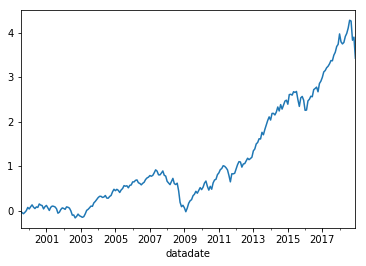

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.071554
2000-12-31    0.016563
2001-12-31   -0.026373
2002-12-31   -0.166083
2003-12-31    0.412472
2004-12-31    0.184199
2005-12-31    0.065265
2006-12-31    0.111401
2007-12-31    0.013761
2008-12-31   -0.369342
2009-12-31    0.354626
2010-12-31    0.191517
2011-12-31    0.017150
2012-12-31    0.196942
2013-12-31    0.411481
2014-12-31    0.120597
2015-12-31    0.000270
2016-12-31    0.122682
2017-12-31    0.211605
2018-12-31   -0.065898
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1823.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.57e-172
Time:                        14:33:52   Log-Likelihood:                 822.00
No. Observations:                 234   AIC:                            -1634.
Df Residuals:                     229   BIC:                            -1617.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.516      0.000       0.001       0.003
mktrf          0.9221      0.014     67.801      0.000       0.895       0.949
me             0.2042      0.016     12.908      0.000       0.173       0.235
ia             0.1213      0.024      5.046      0.000       0.074       0.169
roe            0.0749      0.021      3.637      0.000       0.034       0.115
==============================================================================
Omnibus:                        8.297   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               15.238
Skew:                           0.032   Prob(JB):                     0.000491
Kurtosis:                       4.248   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     961.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.52e-142
Time:                        14:33:52   Log-Likelihood:                 822.00
No. Observations:                 234   AIC:                            -1634.
Df Residuals:                     229   BIC:                            -1617.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.129      0.000       0.001       0.003
mktrf          0.9221      0.018     51.914      0.000       0.887       0.957
me             0.2042      0.036      5.685      0.000       0.134       0.275
ia             0.1213      0.051      2.396      0.017       0.022       0.221
roe            0.0749      0.020      3.752      0.000       0.036       0.114
==============================================================================
Omnibus:                        8.297   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               15.238
Skew:                           0.032   Prob(JB):                     0.000491
Kurtosis:                       4.248   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1193.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.14e-152
Time:                        14:33:52   Log-Likelihood:                 822.00
No. Observations:                 234   AIC:                            -1634.
Df Residuals:                     229   BIC:                            -1617.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.316      0.000       0.001       0.003
mktrf          0.9221      0.016     57.680      0.000       0.891       0.953
me             0.2042      0.034      5.965      0.000       0.137       0.271
ia             0.1213      0.059      2.071      0.038       0.007       0.236
roe            0.0749      0.019      3.841      0.000       0.037       0.113
==============================================================================
Omnibus:                        8.297   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               15.238
Skew:                           0.032   Prob(JB):                     0.000491
Kurtosis:                       4.248   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1448.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.59e-170
Time:                        14:33:52   Log-Likelihood:                 821.68
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     228   BIC:                            -1611.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.596      0.000       0.001       0.003
mktrf          0.9348      0.014     68.352      0.000       0.908       0.962
smb            0.2399      0.018     13.295      0.000       0.204       0.275
hml           -0.0017      0.021     -0.080      0.936      -0.044       0.040
rmw            0.1224      0.024      5.088      0.000       0.075       0.170
cma            0.1008      0.031      3.296      0.001       0.041       0.161
==============================================================================
Omnibus:                       16.528   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.479
Skew:                          -0.058   Prob(JB):                     1.09e-11
Kurtosis:                       5.272   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     688.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.17e-135
Time:                        14:33:53   Log-Likelihood:                 821.68
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     228   BIC:                            -1611.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.281      0.001       0.001       0.003
mktrf          0.9348      0.022     42.382      0.000       0.892       0.978
smb            0.2399      0.028      8.687      0.000       0.186       0.294
hml           -0.0017      0.047     -0.036      0.971      -0.095       0.091
rmw            0.1224      0.024      5.041      0.000       0.075       0.170
cma            0.1008      0.052      1.936      0.053      -0.001       0.203
==============================================================================
Omnibus:                       16.528   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.479
Skew:                          -0.058   Prob(JB):                     1.09e-11
Kurtosis:                       5.272   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     922.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.72e-149
Time:                        14:33:53   Log-Likelihood:                 821.68
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     228   BIC:                            -1611.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.311      0.001       0.001       0.003
mktrf          0.9348      0.021     43.674      0.000       0.893       0.977
smb            0.2399      0.027      8.783      0.000       0.186       0.293
hml           -0.0017      0.053     -0.032      0.975      -0.107       0.103
rmw            0.1224      0.024      5.103      0.000       0.075       0.169
cma            0.1008      0.049      2.041      0.041       0.004       0.198
==============================================================================
Omnibus:                       16.528   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.479
Skew:                          -0.058   Prob(JB):                     1.09e-11
Kurtosis:                       5.272   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1479.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.86e-162
Time:                        14:33:53   Log-Likelihood:                 798.35
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1569.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.866      0.000       0.002       0.004
mktrf          0.9047      0.014     65.304      0.000       0.877       0.932
smb            0.1761      0.017     10.185      0.000       0.142       0.210
hml            0.1247      0.017      7.260      0.000       0.091       0.159
umd            0.0245      0.011      2.174      0.031       0.002       0.047
==============================================================================
Omnibus:                       20.933   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.281
Skew:                           0.114   Prob(JB):                     1.00e-17
Kurtosis:                       5.824   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     811.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.39e-134
Time:                        14:33:53   Log-Likelihood:                 798.35
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1569.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.130      0.000       0.001       0.004
mktrf          0.9047      0.021     43.747      0.000       0.864       0.945
smb            0.1761      0.034      5.171      0.000       0.109       0.243
hml            0.1247      0.057      2.200      0.028       0.014       0.236
umd            0.0245      0.019      1.291      0.197      -0.013       0.062
==============================================================================
Omnibus:                       20.933   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.281
Skew:                           0.114   Prob(JB):                     1.00e-17
Kurtosis:                       5.824   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     971.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.60e-142
Time:                        14:33:53   Log-Likelihood:                 798.35
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1569.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.333      0.000       0.001       0.004
mktrf          0.9047      0.020     45.589      0.000       0.866       0.944
smb            0.1761      0.036      4.949      0.000       0.106       0.246
hml            0.1247      0.067      1.861      0.063      -0.007       0.256
umd            0.0245      0.015      1.610      0.107      -0.005       0.054
==============================================================================
Omnibus:                       20.933   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.281
Skew:                           0.114   Prob(JB):                     1.00e-17
Kurtosis:                       5.824   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     800.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.13e-83
Time:                        14:33:53   Log-Likelihood:                 403.86
No. Observations:                 120   AIC:                            -797.7
Df Residuals:                     115   BIC:                            -783.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.636      0.010       0.001       0.004
mktrf          0.9284      0.022     42.185      0.000       0.885       0.972
me             0.1989      0.022      9.149      0.000       0.156       0.242
ia             0.1788      0.034      5.253      0.000       0.111       0.246
roe            0.0773      0.030      2.565      0.012       0.018       0.137
==============================================================================
Omnibus:                        3.619   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                4.209
Skew:                           0.013   Prob(JB):                        0.122
Kurtosis:                       3.917   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     459.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-69
Time:                        14:33:53   Log-Likelihood:                 403.86
No. Observations:                 120   AIC:                            -797.7
Df Residuals:                     115   BIC:                            -783.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.288      0.022       0.000       0.004
mktrf          0.9284      0.026     35.273      0.000       0.877       0.980
me             0.1989      0.040      4.964      0.000       0.120       0.277
ia             0.1788      0.051      3.514      0.000       0.079       0.279
roe            0.0773      0.020      3.857      0.000       0.038       0.117
==============================================================================
Omnibus:                        3.619   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                4.209
Skew:                           0.013   Prob(JB):                        0.122
Kurtosis:                       3.917   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     797.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.02e-83
Time:                        14:33:53   Log-Likelihood:                 403.86
No. Observations:                 120   AIC:                            -797.7
Df Residuals:                     115   BIC:                            -783.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.409      0.016       0.000       0.004
mktrf          0.9284      0.021     45.064      0.000       0.888       0.969
me             0.1989      0.039      5.042      0.000       0.122       0.276
ia             0.1788      0.054      3.332      0.001       0.074       0.284
roe            0.0773      0.016      4.790      0.000       0.046       0.109
==============================================================================
Omnibus:                        3.619   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                4.209
Skew:                           0.013   Prob(JB):                        0.122
Kurtosis:                       3.917   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     608.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-80
Time:                        14:33:53   Log-Likelihood:                 401.38
No. Observations:                 120   AIC:                            -790.8
Df Residuals:                     114   BIC:                            -774.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.336      0.021       0.000       0.004
mktrf          0.9634      0.024     40.487      0.000       0.916       1.011
smb            0.2530      0.027      9.386      0.000       0.200       0.306
hml            0.0012      0.033      0.036      0.971      -0.064       0.067
rmw            0.1474      0.039      3.784      0.000       0.070       0.225
cma            0.1525      0.043      3.575      0.001       0.068       0.237
==============================================================================
Omnibus:                       10.437   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.481
Skew:                          -0.023   Prob(JB):                     1.78e-06
Kurtosis:                       5.301   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     442.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.64e-73
Time:                        14:33:53   Log-Likelihood:                 401.38
No. Observations:                 120   AIC:                            -790.8
Df Residuals:                     114   BIC:                            -774.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.104      0.035       0.000       0.004
mktrf          0.9634      0.040     24.099      0.000       0.885       1.042
smb            0.2530      0.039      6.450      0.000       0.176       0.330
hml            0.0012      0.081      0.015      0.988      -0.158       0.160
rmw            0.1474      0.053      2.770      0.006       0.043       0.252
cma            0.1525      0.070      2.183      0.029       0.016       0.290
==============================================================================
Omnibus:                       10.437   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.481
Skew:                          -0.023   Prob(JB):                     1.78e-06
Kurtosis:                       5.301   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     843.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.86e-88
Time:                        14:33:53   Log-Likelihood:                 401.38
No. Observations:                 120   AIC:                            -790.8
Df Residuals:                     114   BIC:                            -774.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.351      0.019       0.000       0.004
mktrf          0.9634      0.038     25.373      0.000       0.889       1.038
smb            0.2530      0.038      6.632      0.000       0.178       0.328
hml            0.0012      0.092      0.013      0.990      -0.180       0.182
rmw            0.1474      0.055      2.657      0.008       0.039       0.256
cma            0.1525      0.070      2.176      0.030       0.015       0.290
==============================================================================
Omnibus:                       10.437   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.481
Skew:                          -0.023   Prob(JB):                     1.78e-06
Kurtosis:                       5.301   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     602.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.99e-76
Time:                        14:33:53   Log-Likelihood:                 387.48
No. Observations:                 120   AIC:                            -765.0
Df Residuals:                     115   BIC:                            -751.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.506      0.001       0.001       0.005
mktrf          0.9029      0.022     40.626      0.000       0.859       0.947
smb            0.1829      0.025      7.227      0.000       0.133       0.233
hml            0.1722      0.025      6.796      0.000       0.122       0.222
umd            0.0213      0.016      1.363      0.176      -0.010       0.052
==============================================================================
Omnibus:                       14.533   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               51.322
Skew:                           0.086   Prob(JB):                     7.17e-12
Kurtosis:                       6.199   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     536.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.39e-73
Time:                        14:33:53   Log-Likelihood:                 387.48
No. Observations:                 120   AIC:                            -765.0
Df Residuals:                     115   BIC:                            -751.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.215      0.001       0.001       0.005
mktrf          0.9029      0.032     27.805      0.000       0.839       0.967
smb            0.1829      0.040      4.550      0.000       0.104       0.262
hml            0.1722      0.069      2.492      0.013       0.037       0.308
umd            0.0213      0.021      1.014      0.311      -0.020       0.062
==============================================================================
Omnibus:                       14.533   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               51.322
Skew:                           0.086   Prob(JB):                     7.17e-12
Kurtosis:                       6.199   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     837.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.21e-84
Time:                        14:33:53   Log-Likelihood:                 387.48
No. Observations:                 120   AIC:                            -765.0
Df Residuals:                     115   BIC:                            -751.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.631      0.000       0.001       0.005
mktrf          0.9029      0.027     32.980      0.000       0.849       0.957
smb            0.1829      0.043      4.217      0.000       0.098       0.268
hml            0.1722      0.077      2.224      0.026       0.020       0.324
umd            0.0213      0.018      1.217      0.224      -0.013       0.056
==============================================================================
Omnibus:                       14.533   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               51.322
Skew:                           0.086   Prob(JB):                     7.17e-12
Kurtosis:                       6.199   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1565.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.82e-95
Time:                        14:33:53   Log-Likelihood:                 446.97
No. Observations:                 114   AIC:                            -883.9
Df Residuals:                     109   BIC:                            -870.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.000      4.904      0.000       0.001       0.003
mktrf          0.9211      0.014     63.857      0.000       0.893       0.950
me             0.2149      0.022      9.648      0.000       0.171       0.259
ia            -0.0537      0.031     -1.740      0.085      -0.115       0.007
roe            0.0075      0.027      0.275      0.784      -0.046       0.061
==============================================================================
Omnibus:                        0.538   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.685
Skew:                           0.124   Prob(JB):                        0.710
Kurtosis:                       2.713   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1272.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.85e-90
Time:                        14:33:53   Log-Likelihood:                 446.97
No. Observations:                 114   AIC:                            -883.9
Df Residuals:                     109   BIC:                            -870.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.426      0.000       0.001       0.003
mktrf          0.9211      0.015     59.625      0.000       0.891       0.951
me             0.2149      0.029      7.418      0.000       0.158       0.272
ia            -0.0537      0.034     -1.578      0.115      -0.121       0.013
roe            0.0075      0.029      0.260      0.795      -0.049       0.064
==============================================================================
Omnibus:                        0.538   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.685
Skew:                           0.124   Prob(JB):                        0.710
Kurtosis:                       2.713   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1222.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-89
Time:                        14:33:53   Log-Likelihood:                 446.97
No. Observations:                 114   AIC:                            -883.9
Df Residuals:                     109   BIC:                            -870.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.839      0.000       0.001       0.004
mktrf          0.9211      0.015     60.001      0.000       0.891       0.951
me             0.2149      0.032      6.621      0.000       0.151       0.278
ia            -0.0537      0.039     -1.378      0.168      -0.130       0.023
roe            0.0075      0.025      0.302      0.762      -0.041       0.056
==============================================================================
Omnibus:                        0.538   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.685
Skew:                           0.124   Prob(JB):                        0.710
Kurtosis:                       2.713   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1933.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.64e-104
Time:                        14:33:53   Log-Likelihood:                 471.90
No. Observations:                 114   AIC:                            -931.8
Df Residuals:                     108   BIC:                            -915.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.951      0.000       0.001       0.002
mktrf          0.9239      0.011     83.194      0.000       0.902       0.946
smb            0.2052      0.018     11.384      0.000       0.169       0.241
hml           -0.0671      0.023     -2.917      0.004      -0.113      -0.022
rmw           -0.0432      0.028     -1.534      0.128      -0.099       0.013
cma           -0.0068      0.036     -0.191      0.849      -0.078       0.064
==============================================================================
Omnibus:                        2.355   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                1.868
Skew:                          -0.175   Prob(JB):                        0.393
Kurtosis:                       3.520   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3133.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.00e-115
Time:                        14:33:53   Log-Likelihood:                 471.90
No. Observations:                 114   AIC:                            -931.8
Df Residuals:                     108   BIC:                            -915.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.514      0.000       0.001       0.002
mktrf          0.9239      0.012     80.109      0.000       0.901       0.946
smb            0.2052      0.023      8.971      0.000       0.160       0.250
hml           -0.0671      0.023     -2.891      0.004      -0.113      -0.022
rmw           -0.0432      0.020     -2.128      0.033      -0.083      -0.003
cma           -0.0068      0.046     -0.148      0.882      -0.097       0.083
==============================================================================
Omnibus:                        2.355   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                1.868
Skew:                          -0.175   Prob(JB):                        0.393
Kurtosis:                       3.520   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     5599.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.15e-128
Time:                        14:33:53   Log-Likelihood:                 471.90
No. Observations:                 114   AIC:                            -931.8
Df Residuals:                     108   BIC:                            -915.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.948      0.003       0.001       0.003
mktrf          0.9239      0.011     83.100      0.000       0.902       0.946
smb            0.2052      0.022      9.190      0.000       0.161       0.249
hml           -0.0671      0.022     -3.057      0.002      -0.110      -0.024
rmw           -0.0432      0.021     -2.046      0.041      -0.085      -0.002
cma           -0.0068      0.048     -0.141      0.888      -0.101       0.088
==============================================================================
Omnibus:                        2.355   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                1.868
Skew:                          -0.175   Prob(JB):                        0.393
Kurtosis:                       3.520   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2333.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.40e-104
Time:                        14:33:53   Log-Likelihood:                 469.38
No. Observations:                 114   AIC:                            -928.8
Df Residuals:                     109   BIC:                            -915.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.586      0.001       0.001       0.002
mktrf          0.9289      0.011     82.723      0.000       0.907       0.951
smb            0.2141      0.018     12.230      0.000       0.179       0.249
hml           -0.0430      0.018     -2.383      0.019      -0.079      -0.007
umd            0.0013      0.014      0.095      0.924      -0.026       0.028
==============================================================================
Omnibus:                        3.334   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                3.139
Skew:                          -0.188   Prob(JB):                        0.208
Kurtosis:                       3.721   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2924.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.12e-110
Time:                        14:33:53   Log-Likelihood:                 469.38
No. Observations:                 114   AIC:                            -928.8
Df Residuals:                     109   BIC:                            -915.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.251      0.001       0.001       0.002
mktrf          0.9289      0.012     76.618      0.000       0.905       0.953
smb            0.2141      0.022      9.722      0.000       0.171       0.257
hml           -0.0430      0.013     -3.281      0.001      -0.069      -0.017
umd            0.0013      0.011      0.123      0.902      -0.019       0.022
==============================================================================
Omnibus:                        3.334   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                3.139
Skew:                          -0.188   Prob(JB):                        0.208
Kurtosis:                       3.721   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4450.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.75e-120
Time:                        14:33:53   Log-Likelihood:                 469.38
No. Observations:                 114   AIC:                            -928.8
Df Residuals:                     109   BIC:                            -915.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.801      0.005       0.000       0.002
mktrf          0.9289      0.012     79.217      0.000       0.906       0.952
smb            0.2141      0.021     10.071      0.000       0.172       0.256
hml           -0.0430      0.014     -3.108      0.002      -0.070      -0.016
umd            0.0013      0.012      0.110      0.912      -0.022       0.024
==============================================================================
Omnibus:                        3.334   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                3.139
Skew:                          -0.188   Prob(JB):                        0.208
Kurtosis:                       3.721   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""